# ca数据训练
## 导入相应的包


In [1]:
import os
import sys
import cv2

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

import numpy as np
import tensorflow as tf


# 数据增强
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import MobileNetV2, ResNet50, Xception, EfficientNetB4
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, model_from_json

# 添加路径，以能正常导入mbsh、trainer
sys.path.insert(0, r"E:\projects\znyx-trainer\trainer2")

from mbsh import create_app
from mbsh.core.models import SmallModel
from mbsh.core.images import read_to_pd,TrainArgs
from mbsh.core.plot import Plot

from trainer import Trainer

# tf.compat.v1.disable_eager_execution()

ImportError: cannot import name 'EfficientNetB4'

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
 
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
# model_id = 100 ResNet 模型 loss: 0.2732 - acc: 0.9096 - val_loss: 0.4109 - val_acc: 0.8740

##  路径常量设置

In [5]:
# 样本数据根目录
# 根目录下res中按分类标签存放各类型图像
# cache目录存放训练的结果模型
# 
# root_path = r'/home/endoangel/public/模型算法组/训练数据/zhangkuo/imgs_wei_29'
root_path = r"E:\projects\znyx-trainer\job\口咽部\第8轮"
# 是否使用平衡数据做训练
use_increase = False

# 训练采用的模型名称
model_name = 'effi'


# 模型保存id
model_id = 201


IMG_SIZE = 224
img_size = (IMG_SIZE, IMG_SIZE)

# img_size = (360,360)
# 训练迭代次数
epochs = 3


# 训练每批次样本数
batch_size = 16

In [6]:
# app创建
app = create_app(os.getenv('FLASK_CONFIG') or 'default')
app.app_context().push()

2022-02-25 14:47:16,133 - INFO - __init__.py - create_app - 71 - db url =sqlite:///E:\projects\znyx-trainer\trainer2\../data\production.db


In [7]:
cache_path = root_path + '/cache'
res_path = root_path + '/res'

# res数据分割后的训练和验证集目录
res_train_path = root_path + '/res_train'
res_test_path = root_path + '/res_test'

# 数据平衡后的训练和验证集目录
train_path = root_path + '/train'
test_path = root_path + '/test'

# 图片预测错误存放目录
pred_err_path = root_path + '/pred_err'


# trainer创建

# 从数据库获取model信息，如果数据库还未建立相应的记录可查询一个已存在的，再自行修改sm的desc_list
# sm = SmallModel.query.get(sm_name)

# 生成 trainer
sm_name = 'ca'
sm_desc_list =  ["喉","上颚","咽后壁","右梨状窝","左梨状窝"]
sm = SmallModel(sm_name)

sm.desc_list = sm_desc_list
trainer = Trainer(sm)
trainer.img_size = img_size
trainer.target_fold = root_path

# 类型个数
types_num = len(trainer.desc_list)

desc_list = [str(x) + '-' + trainer.desc_list[x] for x in range(0,types_num)]
print(desc_list)

['0-喉', '1-上颚', '2-咽后壁', '3-右梨状窝', '4-左梨状窝']


## 开始训练
### 数据增强

In [8]:
def img_rgb2_bgr(img):
    return img[: , : , : : -1]

# 图片生成器
# https://keras-cn.readthedocs.io/en/latest/preprocessing/image/#imagedatagenerator
train_datagen =  ImageDataGenerator(       
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        rotation_range=10,
        zoom_range=0.1,
        fill_mode='constant',
#         vertical_flip=True,
#         horizontal_flip=True,
        preprocessing_function = img_rgb2_bgr,
    )

test_datagen =  ImageDataGenerator(
        fill_mode='constant',
        preprocessing_function = img_rgb2_bgr,
    )

# 训练数据与测试数据
cls_mode = 'binary' if types_num == 2 else 'categorical'
train_generator = train_datagen.flow_from_directory(
        res_train_path,
        target_size = img_size,
        batch_size = batch_size,
        class_mode = cls_mode)
test_generator = test_datagen.flow_from_directory(
        res_test_path,
        target_size = img_size,
        batch_size = batch_size,
        class_mode = cls_mode)

train_samples = train_generator.samples
valid_samples = test_generator.samples

Found 1859 images belonging to 5 classes.
Found 344 images belonging to 5 classes.


### 训练
#### 先全部冻结训练

In [9]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
# Create the base model EfficientNetB4
base_model = EfficientNetB4(input_shape=IMG_SHAPE,include_top=False, weights='imagenet')
# 冻结所有层
# base_model.trainable = False
base_model.trainable = True

In [10]:
from tensorflow.keras.optimizers import SGD, Adam
setting = (1, 'sigmoid', 'binary_crossentropy') if types_num == 2 else (types_num, 'softmax', 'categorical_crossentropy')
# Add a classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
prediction = Dense(setting[0], activation=setting[1], name='dense')(x)

model = Model(base_model.input, prediction)

# model = trainer.load_model(22)
base_learning_rate = 0.001

sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
# Adam = Adam(lr=base_learning_rate/10)
model.compile(optimizer=sgd, loss=setting[2], metrics=['accuracy'])


In [11]:
print("Number of layers in the base model: ", len(base_model.layers))
# 在 fine_tune_at 之后放开训练,根据情况修改  175
fine_tune_at = 813

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:fine_tune_at]:
    layer.trainable =  True

Number of layers in the base model:  474


In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [13]:
def fit_gen(model, model_id, epochs=5):
    class_mode = 'binary' if types_num == 2 else 'categorical'
    print("train from imgs model_id=%s ,class_mode=%s" % (model_id, class_mode))
                
    # 创建cache目录
    if not os.path.exists(cache_path):
        os.mkdir(cache_path)
    
    weight_path = cache_path + '/weights' + str(model_id) + '.hdf5'
    
    # EarlyStoppingy原型：
    # EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
    early_stop = EarlyStopping(monitor='val_loss', patience=8)
    
    # ModelCheckpoint原型：
    # ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
    check_point = ModelCheckpoint(weight_path, monitor='val_loss', save_best_only=True, save_weights_only=True)
    
    # callbacks设置
    callbacks = [early_stop, check_point]
    
    
    history = model.fit(
        train_generator,
        epochs = epochs,
        steps_per_epoch = train_samples // batch_size,
        validation_data = test_generator,
        validation_steps = valid_samples // batch_size,
        callbacks = callbacks)
    return history

In [14]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [15]:
history = fit_gen(model, model_id, epochs=50 )

train from imgs model_id=201 ,class_mode=categorical
Epoch 1/50
116/116 [==============================] - 33s 282ms/step - loss: 1.3994 - accuracy: 0.4026 - val_loss: 1.1400 - val_accuracy: 0.6012
Epoch 2/50
116/116 [==============================] - 29s 253ms/step - loss: 0.9166 - accuracy: 0.6907 - val_loss: 0.7721 - val_accuracy: 0.7798
Epoch 3/50
116/116 [==============================] - 29s 252ms/step - loss: 0.6409 - accuracy: 0.7884 - val_loss: 0.5046 - val_accuracy: 0.8542
Epoch 4/50
116/116 [==============================] - 29s 253ms/step - loss: 0.4913 - accuracy: 0.8275 - val_loss: 0.3806 - val_accuracy: 0.8720
Epoch 5/50
116/116 [==============================] - 29s 251ms/step - loss: 0.4005 - accuracy: 0.8584 - val_loss: 0.3027 - val_accuracy: 0.9048
Epoch 6/50
116/116 [==============================] - 29s 253ms/step - loss: 0.3165 - accuracy: 0.8947 - val_loss: 0.2473 - val_accuracy: 0.9137
Epoch 7/50
116/116 [==============================] - 29s 254ms/step - loss: 

## 保存模型

In [16]:
trainer.save_model(model, model_id)

2022-02-25 15:14:57,076 - INFO - trainer.py - save_model - 368 - save model success ,num=201


In [17]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

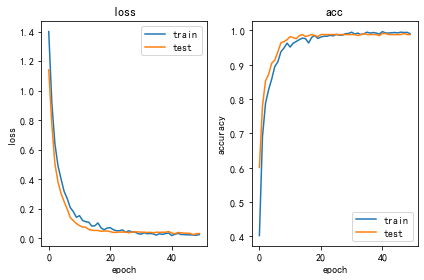

In [18]:
def show_history(history):
    fig, axes = plt.subplots(nrows=1,ncols=2)
    ax=axes[0]

    ax.plot(history['loss'])
    ax.plot(history['val_loss'])
    ax.legend(['train','test'],loc='upper right')
    ax.set_title('loss'.format(1))
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')

    ax=axes[1]
    ax.plot(history['accuracy'])
    ax.plot(history['val_accuracy'])
    ax.legend(['train','test'],loc='best')
    ax.set_title('acc'.format(1))
    ax.set_xlabel('epoch')
    ax.set_ylabel('accuracy')
    fig.tight_layout()
    plt.savefig(os.path.join(root_path,"训练曲线.png"))
    plt.savefig("训练曲线.png")
    plt.show() 
    
show_history(history.history)

## 测试集测试

In [19]:
model_id

201

In [20]:
K.clear_session()
model = None
# trainer.target_fold = r"E:\projects\znyx-trainer\job\resnet_efficient\imgs_me_mang"
model = trainer.load_model(model_id)
# 加载训练中的最优模型
# model.load_weights(trainer.get_weight_file(24))


2022-02-25 15:33:34,765 - INFO - trainer.py - load_model - 353 - load weights 201


find 5 from E:\projects\znyx-trainer\job\口咽部\第7轮_整图\valid_date
load data from fold finished ,count=181
6/6 [==============================] - 1s 193ms/step


2022-02-25 15:33:40,646 - INFO - plot.py - show_matrix - 167 - save plot image to E:\projects\znyx-trainer\job\口咽部\第8轮\2022-02-25-15-33_57.png 
2022-02-25 15:33:40,646 - INFO - plot.py - show_matrix - 174 - accurracy:0.9779005524861879


cast-363ms, fold: ['E:\\projects\\znyx-trainer\\job\\口咽部\\第7轮_整图\\valid_date'] ,accurracy:97
Confusion matrix, without normalization
[[90  0  0  0  0]
 [ 0 25  1  0  0]
 [ 0  0 30  0  0]
 [ 0  2  0 24  0]
 [ 0  0  0  1  8]]


<Figure size 432x288 with 0 Axes>

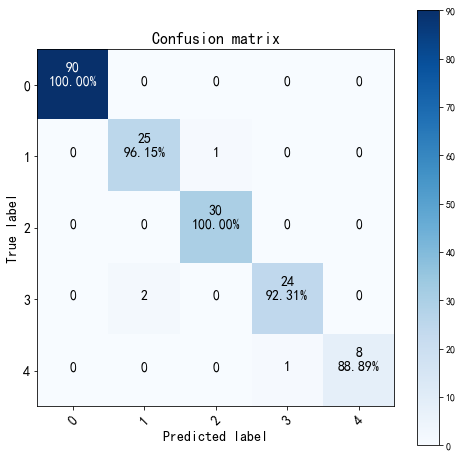

['0-喉', '1-上颚', '2-咽后壁', '3-右梨状窝', '4-左梨状窝']


In [21]:
use_increase = True
# 显示预测准确度、混淆矩阵，保持混淆矩阵图到root_path
test_path = r"E:\projects\znyx-trainer\job\口咽部\第7轮_整图\valid_date"
acc, y_pred, y_true, file_test = trainer.predict_data([test_path if use_increase else res_test_path], model = model)
path = Plot.show_matrix(y_pred, y_true, types_num, root_path)
plt.show()

print(desc_list)    

find 5 from E:\projects\znyx-trainer\job\口咽部\第6轮\valid_data
load data from fold finished ,count=170
6/6 [==============================] - 1s 175ms/step


2022-02-23 10:37:54,930 - INFO - plot.py - show_matrix - 167 - save plot image to E:\projects\znyx-trainer\job\口咽部\第6轮\2022-02-23-10-37_383.png 
2022-02-23 10:37:54,931 - INFO - plot.py - show_matrix - 174 - accurracy:0.9588235294117647


cast-58ms, fold: ['E:\\projects\\znyx-trainer\\job\\口咽部\\第6轮\\valid_data'] ,accurracy:95
Confusion matrix, without normalization
[[90  0  0  0  0]
 [ 0 25  1  0  0]
 [ 0  0 30  0  0]
 [ 0  0  0 16  0]
 [ 1  0  0  5  2]]


<Figure size 432x288 with 0 Axes>

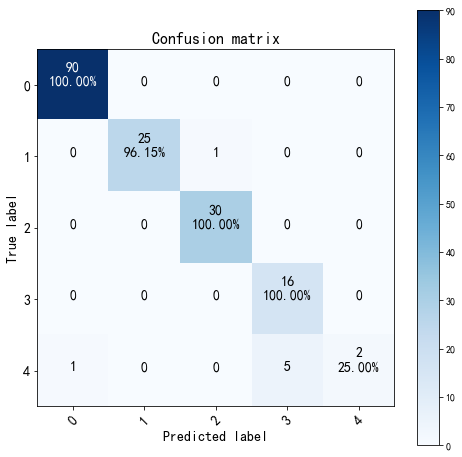

['0-喉', '1-上颚', '2-咽后壁', '3-右梨状窝', '4-左梨状窝']


In [9]:
use_increase = True
# 显示预测准确度、混淆矩阵，保持混淆矩阵图到root_path
test_path = r"E:\projects\znyx-trainer\job\口咽部\第6轮\valid_data"
acc, y_pred, y_true, file_test = trainer.predict_data([test_path if use_increase else res_test_path], model = model)
path = Plot.show_matrix(y_pred, y_true, types_num, root_path)
plt.show()

print(desc_list)    

In [ ]:
use_increase = True
# 显示预测准确度、混淆矩阵，保持混淆矩阵图到root_path
acc, y_pred, y_true, file_test = trainer.predict_data([test_path if use_increase else res_test_path], model = model,binary_threshold=optimal_threshold)
path = Plot.show_matrix(y_pred, y_true, types_num, root_path)
plt.show()

print(desc_list)

In [ ]:
acc: 98.51%
0: 98.69%
1: 98.35%

In [20]:
from datetime import datetime
def predict_imgs(imgs_path0,imgs_path1,model):
    # 获取该路径下所有图片
    files_list0=fetch_all_files(imgs_path0,file_exts=[".jpg", ".Jpg", ".jpeg", ".PNG", ".png", ".Bmp", ".bmp", ".BMP", ".JPG"])
    files_list0=sort_by_file_name(files_list0)

    files_list1=fetch_all_files(imgs_path1,file_exts=[".jpg", ".Jpg", ".jpeg", ".PNG", ".png", ".Bmp", ".bmp", ".BMP", ".JPG"])
    files_list1=sort_by_file_name(files_list1)
    
    label0 = [0] * len(files_list0)
    label1 = [1] * len(files_list1)
    files_list = files_list0 + files_list1
    label = label0 + label1
    x_test = []
    X = []

    for file in files_list:
        img = read_img_file(file)
        img = cv2.resize(img,(224,224))
        x_test.append(img)

    for x in x_test:
        x = np.array(x,dtype="float32")
        if x.shape[2] != 3:
            x = x[:, :, :3]
        X.append(x)

    X= np.asarray(X)

    predictions_list = model.predict(X, verbose=1)
    
    start_time = datetime.now().timestamp()
    for x in x_test[:100]:
        x = np.array(x,dtype="float32")
        if x.shape[2] != 3:
            x = x[:, :, :3]
        data = np.expand_dims(x, axis=0)
        predictions = model.predict(data)[0]
    end_time = datetime.now().timestamp()
    during_time = end_time - start_time
    
    return label,predictions_list,files_list,during_time

def cal_acc(label,pred):
    print("阈值   综合精度          灵敏度            特异度   ")
    for tr in [ x for x in range(1,101,1)]:
        tn,tp,P_all,N_all =0,0,0,0

        for i,y_true in enumerate(label):
            if y_true ==0:
                N_all+=1
                if pred[i]>tr:
                    y_pred =1
                else:
                    y_pred =0
                if y_pred == y_true:
                    tn+=1
            if y_true ==1:
                P_all+=1
                if pred[i]>tr:
                    y_pred =1
                else:
                    y_pred =0
                if y_pred == y_true:
                    tp+=1
        
        print(tr,(tp+tn)/(P_all+N_all),tp/P_all,tn/N_all)

In [21]:
from mbsh.core.images import sort_by_file_name,load_img_data,fetch_all_files,read_img_file
imgs_path0 = r"E:\projects\znyx-trainer\job\resnet_efficient\imgs_me_ca\gl_whu_test\0"
imgs_path1 = r"E:\projects\znyx-trainer\job\resnet_efficient\imgs_me_ca\gl_whu_test\1"
label,predictions_list,files_list,time = predict_imgs(imgs_path0,imgs_path1,model)

49/49 [==============================] - 5s 96ms/step


In [22]:
print(time)

3.1885647773742676


In [23]:
pred = []
for prediction in predictions_list:
    conf = (prediction[0])*100
    pred.append(conf)
    
from sklearn.metrics import roc_curve, auc
fpr,tpr,thresholds = roc_curve(label,pred)
roc_auc = auc(fpr, tpr)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("最佳阈值：%s  ROC面积：%s"%(optimal_threshold,roc_auc))

cal_acc(label,pred)

最佳阈值：8.858472853899002  ROC面积：0.9719418564527259
阈值   综合精度          灵敏度            特异度   
1 0.7037037037037037 0.9875776397515528 0.5738636363636364
2 0.8310591293047433 0.9648033126293996 0.7698863636363636
3 0.8745938921377517 0.9565217391304348 0.8371212121212122
4 0.8953866146848602 0.9316770186335404 0.8787878787878788
5 0.907732293697206 0.9109730848861284 0.90625
6 0.9155295646523717 0.8985507246376812 0.9232954545454546
7 0.916829109811566 0.8861283643892339 0.9308712121212122
8 0.9207277452891488 0.8799171842650103 0.9393939393939394
9 0.9259259259259259 0.8674948240165632 0.9526515151515151
10 0.9252761533463287 0.8530020703933747 0.9583333333333334
11 0.9272254710851202 0.8488612836438924 0.9630681818181818
12 0.9259259259259259 0.8364389233954451 0.9668560606060606
13 0.9252761533463287 0.8281573498964804 0.9696969696969697
14 0.9246263807667316 0.8178053830227743 0.9734848484848485
15 0.9246263807667316 0.8115942028985508 0.9763257575757576
16 0.9213775178687459 0.79917184